In [290]:
import pandas as pd
from basics import get_df
import numpy as np

answers = []
df = get_df()
df['possession_away'] = df['possession_away'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['possession_home'] = df['possession_home'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['home_team'] = df['home']
columns = ['season', 'away', 'home', 'neutral',
       'score_away', 'score_home', 'first_downs_away', 'first_downs_home',
       'first_downs_from_passing_away', 'first_downs_from_passing_home',
       'first_downs_from_rushing_away', 'first_downs_from_rushing_home',
       'first_downs_from_penalty_away', 'first_downs_from_penalty_home',
       'third_down_comp_away', 'third_down_att_away', 'third_down_comp_home',
       'third_down_att_home', 'fourth_down_comp_away', 'fourth_down_att_away',
       'fourth_down_comp_home', 'fourth_down_att_home', 'plays_away',
       'plays_home', 'drives_away', 'drives_home', 'yards_away', 'yards_home',
       'pass_comp_away', 'pass_att_away', 'pass_yards_away', 'pass_comp_home',
       'pass_att_home', 'pass_yards_home', 'sacks_num_away',
       'sacks_yards_away', 'sacks_num_home', 'sacks_yards_home',
       'rush_att_away', 'rush_yards_away', 'rush_att_home', 'rush_yards_home',
       'pen_num_away', 'pen_yards_away', 'pen_num_home', 'pen_yards_home',
       'redzone_comp_away', 'redzone_att_away', 'redzone_comp_home',
       'redzone_att_home', 'fumbles_away', 'fumbles_home',
       'interceptions_away', 'interceptions_home', 'def_st_td_away',
       'def_st_td_home', 'possession_away', 'possession_home']

col_home_as_a = {}

for col in columns:
    if '_away' in col:
        col_home_as_a[col] = col.replace('_away', '_B')
    elif '_home' in col:
        col_home_as_a[col] = col.replace('_home', '_A')
    elif col == 'home':
        col_home_as_a[col] = 'team_A'
    elif col == 'away':
        col_home_as_a[col] = 'team_B'
    else:
        col_home_as_a[col] = col  # Keep neutral columns unchanged
        
col_home_as_b = {}

for col in columns:
    if '_away' in col:
        col_home_as_b[col] = col.replace('_away', '_A')
    elif '_home' in col:
        col_home_as_b[col] = col.replace('_home', '_B')
    elif col == 'home':
        col_home_as_b[col] = 'team_B'
    elif col == 'away':
        col_home_as_b[col] = 'team_A'
    else:
        col_home_as_b[col] = col  # Keep neutral columns unchanged

df_A = df.rename(columns=col_home_as_a)
df_B = df.rename(columns=col_home_as_b)

full = pd.concat([df_A, df_B], ignore_index=True)
full.sort_values(by=['season','week', 'date'], inplace=True)
#full.to_csv("./temp_full.csv")
#print(full.head())



def consolidate_game_stats(df):
    # Ensure Team A is always the first team alphabetically

    df['third_down_conv_rate_A'] = (df['third_down_comp_A'] / df['third_down_att_A']) * 100
    df['third_down_conv_rate_B'] = (df['third_down_comp_B'] / df['third_down_att_B']) * 100
    df['redzone_conv_rate_A'] = (df['redzone_comp_A'] / df['redzone_att_A']) * 100
    df['redzone_conv_rate_B'] = (df['redzone_comp_B'] / df['redzone_att_B']) * 100
    df['turnovers_A'] = df['interceptions_A'] + df['fumbles_A']
    df['turnovers_B'] = df['interceptions_B'] + df['fumbles_B']
    # Determine the winner (1 if Team A wins, 0 if Team B wins)


    return df
full = pd.read_csv("/Users/jcklvrgn/Documents/GitHub/NFL_predictor/Football/full_df.csv")

consolidated_data = consolidate_game_stats(full)
consolidated_data = consolidated_data.assign(
    score_diff = consolidated_data['score_A'] - consolidated_data['score_B'],
    yards_diff = consolidated_data['yards_A'] - consolidated_data['yards_B'],
    pass_yards_diff=consolidated_data['pass_yards_A'] - consolidated_data['pass_yards_B'],
    rush_yards_diff = consolidated_data['rush_yards_A'] - consolidated_data['rush_yards_B'],
    turnovers_diff =  - consolidated_data['turnovers_A'] - consolidated_data['turnovers_B'],
    first_downs_diff = consolidated_data['first_downs_A'] - consolidated_data["first_downs_B"],
    third_down_conv_diff = consolidated_data['third_down_conv_rate_A'] - consolidated_data['third_down_conv_rate_B'],
    redzone_conv_rate_diff = consolidated_data['redzone_conv_rate_A'] - consolidated_data['redzone_conv_rate_B'],
    possession_diff = consolidated_data['possession_A']-consolidated_data['possession_B'],
    yards_per_play_A = consolidated_data['yards_A'] / consolidated_data['plays_A'],
    yards_per_play_B = consolidated_data['yards_B'] / consolidated_data['plays_B'],
    def_st_td_diff = consolidated_data['def_st_td_A'] - consolidated_data['def_st_td_B'],
    sack_diff = consolidated_data['sacks_num_A'] - consolidated_data['sacks_num_B']
    

)
consolidated_data = consolidated_data.assign(interaction_1 = consolidated_data['yards_diff'] * consolidated_data['turnovers_diff'],
    interaction_3 = consolidated_data['rush_yards_diff'] * consolidated_data['pass_yards_diff'],
    turnovers_per_drive_A = consolidated_data['turnovers_A'] / consolidated_data['drives_A'],
    turnovers_per_drive_B = consolidated_data['turnovers_B'] / consolidated_data['drives_B']
)

consolidated_data = consolidated_data.assign(interaction_2 = consolidated_data['third_down_conv_diff']* consolidated_data['interaction_1'],
    yards_per_play_diff = consolidated_data['yards_per_play_A'] - consolidated_data['yards_per_play_B'],
    turnovers_per_drive_diff = consolidated_data['turnovers_per_drive_A'] - consolidated_data['turnovers_per_drive_B'],
    interaction_4 = consolidated_data['interaction_1'] * consolidated_data['interaction_3'],
    )
consolidated_data = consolidated_data.assign(interaction_5 = consolidated_data['pen_yards_A']* consolidated_data['interaction_1'])
consolidated_data.drop('Unnamed: 0', axis=1, inplace=True)
print(consolidated_data.columns)
#consolidated_data.to_csv('./consolidated.csv')
# yards_diff: Difference in total yards.

# pass_yards_diff: Difference in passing yards.

# rush_yards_diff: Difference in rushing yards.

# turnovers_diff: Difference in turnovers (e.g., Team A's turnovers - Team B's turnovers).
#print(consolidated_data)

Index(['season', 'week', 'date', 'time_et', 'neutral', 'team_B', 'team_A',
       'score_B', 'score_A', 'first_downs_B', 'first_downs_A',
       'first_downs_from_passing_B', 'first_downs_from_passing_A',
       'first_downs_from_rushing_B', 'first_downs_from_rushing_A',
       'first_downs_from_penalty_B', 'first_downs_from_penalty_A',
       'third_down_comp_B', 'third_down_att_B', 'third_down_comp_A',
       'third_down_att_A', 'fourth_down_comp_B', 'fourth_down_att_B',
       'fourth_down_comp_A', 'fourth_down_att_A', 'plays_B', 'plays_A',
       'drives_B', 'drives_A', 'yards_B', 'yards_A', 'pass_comp_B',
       'pass_att_B', 'pass_yards_B', 'pass_comp_A', 'pass_att_A',
       'pass_yards_A', 'sacks_num_B', 'sacks_yards_B', 'sacks_num_A',
       'sacks_yards_A', 'rush_att_B', 'rush_yards_B', 'rush_att_A',
       'rush_yards_A', 'pen_num_B', 'pen_yards_B', 'pen_num_A', 'pen_yards_A',
       'redzone_comp_B', 'redzone_att_B', 'redzone_comp_A', 'redzone_att_A',
       'fumbles_B', 'f

In [302]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

top_features = [ 'third_down_conv_diff', 'pen_yards_B', 'rush_yards_A',
    'possession_A', 'yards_diff', 'rush_yards_diff',
    'rush_yards_B', 'pen_yards_A',
    'possession_B', 'redzone_conv_rate_diff', 'pass_att_B',  
    
    'first_downs_diff', 'yards_per_play_diff', 'turnovers_per_drive_diff', 'def_st_td_diff', 'sack_diff', 'pass_yards_diff'
]
to_remove = ['yards_A', 'possession_diff', 'pass_yards_diff', 'yards_diff', 'interaction_4', 'interaction_2', 'interaction_1', 'interaction_5', 'plays_B', 'interaction_3', 'turnovers_diff']
# Features and target
#X = consolidated_data[['yards_diff', 'pass_yards_diff', 'rush_yards_diff', 'turnovers_diff','first_downs_diff', 'third_down_conv_diff', 'redzone_conv_rate_diff','yard_turnover_mult']]  # Add more features
#X = consolidated_data[['third_down_conv_diff','first_downs_diff', 'yards_diff', 'redzone_conv_rate_diff', 'redzone_att_A', 'redzone_att_B', 'yard_turnover_mult', 'possession_diff']]
X = consolidated_data[top_features]
team_to_check = consolidated_data['team_A']
y = (consolidated_data['winner'] == team_to_check).astype(int)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
answers.append(f'Accuracy for sklearn: {score}')
print("Accuracy:", score)


Accuracy: 0.8731028667790893


In [303]:
X.head(2)

,third_down_conv_diff,pen_yards_B,rush_yards_A,possession_A,yards_diff,rush_yards_diff,rush_yards_B,pen_yards_A,possession_B,redzone_conv_rate_diff,pass_att_B,first_downs_diff,yards_per_play_diff,turnovers_per_drive_diff,def_st_td_diff,sack_diff,pass_yards_diff
0,22.916667,29,43,1948,82,-70,113,80,1652,0.0,26,8,-0.313445,0.123077,0,3,152
1,-22.916667,80,113,1652,-82,70,43,29,1948,0.0,45,-8,0.313445,-0.123077,0,-3,-152


In [304]:
from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

In [305]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
display(feature_importance_df)

,Feature,Importance
13,turnovers_per_drive_diff,0.221847
12,yards_per_play_diff,0.097600
5,rush_yards_diff,0.088866
0,third_down_conv_diff,0.080067
4,yards_diff,0.060670
10,pass_att_B,0.058757
15,sack_diff,0.057550
8,possession_B,0.050258
3,possession_A,0.044321
2,rush_yards_A,0.033013


In [306]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


# Convert DataFrame to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',        # Logarithmic loss for evaluation
    'max_depth': 6,                  # Maximum depth of a tree
    'eta': 0.1,                      # Learning rate
    'subsample': 0.8,                # Subsample ratio of the training instances
    'colsample_bytree': 0.8,         # Subsample ratio of columns
    'seed': 42                       # Random seed for reproducibility
}

# Train the model
num_rounds = 100  # Number of boosting rounds
model_xgb = xgb.train(params, dtrain, num_rounds)

# Make predictions
y_pred_proba = model_xgb.predict(dtest)  # Predicted probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model
score = accuracy_score(y_test, y_pred)
answers.append(f"xgb: {score}")
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)



XGBoost Accuracy: 0.892495784148398
[[1072  131]
 [ 124 1045]]


[LightGBM] [Info] Number of positive: 4760, number of negative: 4726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3096
[LightGBM] [Info] Number of data points in the train set: 9486, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501792 -> initscore=0.007168
[LightGBM] [Info] Start training from score 0.007168
LightGBM Accuracy: 0.8857504215851602


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

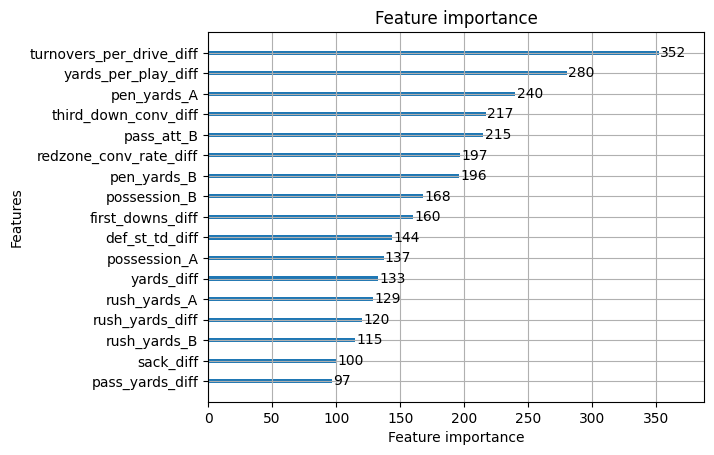

In [307]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'objective': 'binary',           # Binary classification
    'metric': 'binary_logloss',      # Logarithmic loss for evaluation
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Tree
    'num_leaves': 31,                # Maximum number of leaves in one tree
    'learning_rate': 0.1,            # Learning rate
    'feature_fraction': 0.8,         # Subsample ratio of features
    'bagging_fraction': 0.8,         # Subsample ratio of data
    'bagging_freq': 5,               # Frequency for bagging
    'seed': 42                       # Random seed for reproducibility
}

# Train the model
num_rounds = 100  # Number of boosting rounds
model_lgb = lgb.train(params, train_data, num_rounds, valid_sets=[test_data])

# Make predictions
y_pred_proba = model_lgb.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model
score = accuracy_score(y_test, y_pred)
answers.append(f'lgb: {score}')
print("LightGBM Accuracy:", score)

lgb.plot_importance(model_lgb)


In [308]:


# Use only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Retrain the model
model_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)
model_xgb.fit(X_train_top, y_train)

# Evaluate the model
y_pred = model_xgb.predict(X_test_top)
print("Accuracy with Top Features:", accuracy_score(y_test, y_pred))


Accuracy with Top Features: 0.8916526138279932


Confusion Matrix:
[[1072  131]
 [ 126 1043]]


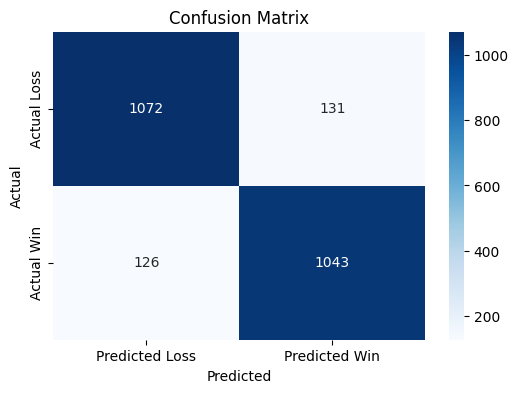

In [309]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model_xgb.predict(X_test_top)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Loss', 'Predicted Win'], 
            yticklabels=['Actual Loss', 'Actual Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [310]:
print(answers)
answer_df = pd.DataFrame([answers])
answer_df.to_csv('./answers.csv', mode='a', header=False, index=False)
answers = []

['Accuracy for sklearn: 0.8731028667790893', 'xgb: 0.892495784148398', 'lgb: 0.8857504215851602']


In [311]:
input_row = {
    'third_down_conv_diff': 3.3,  # a: 0.45, b: 0.417, diff = 0.033
    'pen_yards_B': 46.65,           # b: 46.65
    'rush_yards_A': 105.3,          # a: 105.3
    'possession_A': 1866,           # a: 1866
    'yards_diff': -39.57,           # a: 327.6, b: 367.17, diff = -39.57
    'rush_yards_diff': -73.99,      # a: 105.3, b: 179.29, diff = -73.99
    'pass_yards_diff': 34.52,       # a: 222.4, b: 187.88, diff = 34.52
    'yards_A': 327.6,               # a: 327.6
    'rush_yards_B': 179.29,         # b: 179.29
    'pen_yards_A': 48.76,           # a: 48.76
    'possession_B': 1942,           # b: 1942
    'redzone_conv_rate_diff': -3.45,  # a: 0.5395, b: 0.5740, diff = -0.0345
    'possession_diff': -76,         # a: 1866, b: 1942, diff = -76
    'pass_att_B': 26.35,            # b: 26.35
    'plays_A': 64.18,               # a: 64.18
    'sacks_yards_A': 14.27,         # a: 14.27
    'sacks_yards_B': 18,            # b: 18
    'plays_B': 65.53,               # b: 65.53
    'first_downs_diff': -0.59,      # kc: 20.59, eag: 21.18, diff = -0.59
    'yards_B': 367.17,              # b: 367.17
    'yards_per_play_diff': -0.5,    # kc: 5.1, eag: 5.6, diff = -0.5
    'turnovers_per_drive_diff': 0.0004,  # chief: 0.0828, eag: 0.0824, diff = 0.0004
    'interaction_1': 2.3267,        # int1: 2.3267
    'interaction_2': 7.67811,       # int2: 0.07678
    'interaction_3': 2554.1348,      # int3: 2554.1348
    'interaction_4' : 5942.705439,
    'interaction_5': 113.449892,
    'turnovers_diff': -0.0588,
    'def_st_td_diff': 0,
    'sack_diff': 0.5882352942,
}

input_row_flipped = {
    'third_down_conv_diff': -3.3,  # b: 0.417, a: 0.45, diff = -0.033
    'pen_yards_B': 48.76,            # a: 48.76 (now assigned to Team B)
    'rush_yards_A': 179.29,          # b: 179.29 (now assigned to Team A)
    'possession_A': 1942,            # b: 1942 (now assigned to Team A)
    'yards_diff': 39.57,             # b: 367.17, a: 327.6, diff = 39.57
    'rush_yards_diff': 73.99,        # b: 179.29, a: 105.3, diff = 73.99
    'pass_yards_diff': -34.52,       # b: 187.88, a: 222.4, diff = -34.52
    'yards_A': 367.17,               # b: 367.17 (now assigned to Team A)
    'rush_yards_B': 105.3,           # a: 105.3 (now assigned to Team B)
    'pen_yards_A': 46.65,            # b: 46.65 (now assigned to Team A)
    'possession_B': 1866,            # a: 1866 (now assigned to Team B)
    'redzone_conv_rate_diff': 3.45,  # b: 0.5740, a: 0.5395, diff = 0.0345
    'possession_diff': 76,           # b: 1942, a: 1866, diff = 76
    'pass_att_B': 35.29,             # a: 35.29 (now assigned to Team B)
    'plays_A': 65.53,                # b: 65.53 (now assigned to Team A)
    'sacks_yards_A': 18,             # b: 18 (now assigned to Team A)
    'sacks_yards_B': 14.27,          # a: 14.27 (now assigned to Team B)
    'plays_B': 64.18,                # a: 64.18 (now assigned to Team B)
    'first_downs_diff': 0.59,        # eag: 21.18, kc: 20.59, diff = 0.59
    'yards_B': 327.6,                # a: 327.6 (now assigned to Team B)
    'yards_per_play_diff': 0.5,      # eag: 5.6, kc: 5.1, diff = 0.5
    'turnovers_per_drive_diff': -0.0004,  # eag: 0.0824, chief: 0.0828, diff = -0.0004
    'interaction_1': 2.3267,        # int1: 2.3267
    'interaction_2': -7.67811,       # int2: 0.07678
    'interaction_3': -2554.1348,
    'interaction_4': -5942.705439,
    'interaction_5': 108.540555,
    'turnovers_diff': 0.0588,
    'def_st_td_diff': 0,
    'sack_diff': 0.5882352942
}

chief = pd.DataFrame([input_row])
eagle = pd.DataFrame([input_row_flipped])


# Ensure the columns are in the same order as the training data
chief = chief[top_features]  # Use the same feature order as X_train_top
eagle = eagle[top_features]
# Predict the class (0 or 1)

predicted_class_ch = model_xgb.predict(chief)
predicted_class_eag = model_xgb.predict(eagle)


# # Predict the probability of each class
predicted_chief = model_xgb.predict_proba(chief)
predicted_eag = model_xgb.predict_proba(eagle)
res = ['chiefs', predicted_class_ch, predicted_chief, ' eagles',predicted_class_eag, predicted_eag]
print("Predicted Class (Chiefs):", predicted_class_ch[0])
print("Predicted Probabilities:", predicted_chief[0])
print('')
print("Predicted Class (Eagles):", predicted_class_eag[0])
print("Predicted Probabilities:", predicted_eag[0])



Predicted Class (Chiefs): 0
Predicted Probabilities: [0.91532207 0.08467793]

Predicted Class (Eagles): 0
Predicted Probabilities: [0.60453033 0.39546964]


In [312]:
super_df = pd.DataFrame([res])
super_df.to_csv('./chiefgle.csv', mode='a', header=False, index=False)
answers = []